<a href="https://www.kaggle.com/code/ishwor2048/diabetes-prediction-catboost-update?scriptVersionId=286057672" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1><b>KAGGLE PLAYGROUND S5E12 – ROBUST SOLUTION NOTEBOOK

<h3><b>Import necessary libraries and modules

In [1]:
# --------------------------
# Basic Libraries
# --------------------------
import numpy as np
import pandas as pd
import random
import os

# ------------------------
# Data visualization libraries
# ------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------------------
# Scikit-learn for machine learning models, CV, evaluation and preprocessing
# --------------------------------------
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer

import lightgbm as lgb
from catboost import CatBoostClassifier

<h3><b>Reproducibility

In [2]:
# Setting the  seed value
SEED = 42

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)

set_seed()

<h3><b>Load Dataset

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s5e12/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e12/test.csv")

In [4]:
print(f"There are {train.shape[0]} number of rows and {train.shape[1]} number of columns in the training dataset")

There are 700000 number of rows and 26 number of columns in the training dataset


In [5]:
test.shape

(300000, 25)

In [6]:
train.head()

,id,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,...,gender,ethnicity,education_level,income_level,smoking_status,employment_status,family_history_diabetes,hypertension_history,cardiovascular_history,diagnosed_diabetes
0,0,31,1,45,7.7,6.8,6.1,33.4,0.93,112,...,Female,Hispanic,Highschool,Lower-Middle,Current,Employed,0,0,0,1.0
1,1,50,2,73,5.7,6.5,5.8,23.8,0.83,120,...,Female,White,Highschool,Upper-Middle,Never,Employed,0,0,0,1.0
2,2,32,3,158,8.5,7.4,9.1,24.1,0.83,95,...,Male,Hispanic,Highschool,Lower-Middle,Never,Retired,0,0,0,0.0
3,3,54,3,77,4.6,7.0,9.2,26.6,0.83,121,...,Female,White,Highschool,Lower-Middle,Current,Employed,0,1,0,1.0
4,4,54,1,55,5.7,6.2,5.1,28.8,0.90,108,...,Male,White,Highschool,Upper-Middle,Never,Retired,0,1,0,1.0


<h3><b>Define Training Features and Target variable (X, y)

In [7]:
TARGET = "diagnosed_diabetes" # based on the problem given, choosing diagnosed_diabetes as target variable
ID_COL = "id" # ID column would not have much value on the training and prediction quality, flagging it to exclude

# training features
features = [c for c in train.columns if c not in [TARGET, ID_COL]]

X = train[features].copy()
y = train[TARGET].copy()

X_test = test[features].copy()



<h3><b>Identify Numerical & Categorical Column

In [8]:
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

In [9]:
print(f"Categorical Columns: {cat_cols}")
print("---------------------------------------------------------")
print(f"Numerical Columns: {num_cols}")

Categorical Columns: ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']
---------------------------------------------------------
Numerical Columns: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history']


<h3><b>Domain-Aware Feature Engineering

In [10]:
# Function to create domain specific features that add value to the ROC
def add_features(df):
    df["bp_ratio"] = df["systolic_bp"] / (df["diastolic_bp"] + 1)
    df["chol_ratio"] = df["ldl_cholesterol"] / (df["hdl_cholesterol"] + 1)
    df["activity_per_age"] = df["physical_activity_minutes_per_week"] / (df["age"] + 1)
    df["screen_sleep_ratio"] = df["screen_time_hours_per_day"] / (df["sleep_hours_per_day"] + 0.1)
    df["bmi_waist_interaction"] = df["bmi"] * df["waist_to_hip_ratio"]
    return df

In [11]:
X = add_features(X)
X_test = add_features(X_test)

<h3><b>Convert Categorical Columns for Tree models

In [12]:
for col in cat_cols:
    X[col] = X[col].astype("category")
    X_test[col] = X_test[col].astype("category")

<h3><b>Cross-validation Setup

In [13]:
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

<h3><b>Model 1 — Logistic Regression (Baseline)

In [14]:
# Preprocessing for linear model
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", __import__("sklearn").preprocessing.OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols),
])

log_reg = Pipeline([
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

oof_lr = np.zeros(len(X))
test_lr = np.zeros(len(X_test))

for fold, (tr, val) in enumerate(skf.split(X, y), 1):
    log_reg.fit(X.iloc[tr], y.iloc[tr])
    oof_lr[val] = log_reg.predict_proba(X.iloc[val])[:, 1]
    test_lr += log_reg.predict_proba(X_test)[:, 1] / N_SPLITS

print("LogReg CV AUC:", roc_auc_score(y, oof_lr))

LogReg CV AUC: 0.6945058224295144


<h3><b>Model 2: LightGBM (Regularized)

In [15]:
lgb_params = {
    "objective": "binary",
    "metric": "auc",
    "learning_rate": 0.015,
    "num_leaves": 24,
    "max_depth": 6,
    "min_data_in_leaf": 80,
    "feature_fraction": 0.7,
    "bagging_fraction": 0.7,
    "bagging_freq": 1,
    "lambda_l1": 5,
    "lambda_l2": 10,
    "max_cat_to_onehot": 4,
    "verbose": -1,
    "seed": SEED,
}

oof_lgb = np.zeros(len(X))
test_lgb = np.zeros(len(X_test))

for fold, (tr, val) in enumerate(skf.split(X, y), 1):
    dtrain = lgb.Dataset(X.iloc[tr], y.iloc[tr], categorical_feature=cat_cols)
    dvalid = lgb.Dataset(X.iloc[val], y.iloc[val], categorical_feature=cat_cols)

    model = lgb.train(
        lgb_params,
        dtrain,
        num_boost_round=5000,
        valid_sets=[dvalid],
        callbacks=[lgb.early_stopping(200)]
    )

    oof_lgb[val] = model.predict(X.iloc[val])
    test_lgb += model.predict(X_test) / N_SPLITS

print("LightGBM CV AUC:", roc_auc_score(y, oof_lgb))

Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4944]	valid_0's auc: 0.728346
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4990]	valid_0's auc: 0.727129
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4986]	valid_0's auc: 0.728284
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4959]	valid_0's auc: 0.728995
Training until validation scores don't improve for 200 rounds
Did not meet early stopping. Best iteration is:
[4986]	valid_0's auc: 0.728679
LightGBM CV AUC: 0.7282857389783468


<h3><b>Model 3 — CatBoost (KEY MODEL)

In [16]:
cat_features_idx = [X.columns.get_loc(c) for c in cat_cols]

oof_cat = np.zeros(len(X))
test_cat = np.zeros(len(X_test))

for fold, (tr, val) in enumerate(skf.split(X, y), 1):
    model = CatBoostClassifier(
        iterations=3000,
        learning_rate=0.03,
        depth=6,
        l2_leaf_reg=10,
        subsample=0.8,
        loss_function="Logloss",
        eval_metric="AUC",
        cat_features=cat_features_idx,
        random_seed=SEED,
        early_stopping_rounds=200,
        verbose=False
    )

    model.fit(X.iloc[tr], y.iloc[tr], eval_set=(X.iloc[val], y.iloc[val]))
    oof_cat[val] = model.predict_proba(X.iloc[val])[:, 1]
    test_cat += model.predict_proba(X_test)[:, 1] / N_SPLITS

print("CatBoost CV AUC:", roc_auc_score(y, oof_cat))

CatBoost CV AUC: 0.726383385948528


<h3><b>Final Ensemble (Robust Weights)

In [17]:
oof_final = (
    0.5 * oof_cat + 
    0.3 * oof_lgb + 
    0.2 * oof_lr
)

test_final = (
    0.5 * test_cat + 
    0.3 * test_lgb + 
    0.2 * test_lr
)

print("Final Ensemble CV AUC: ", roc_auc_score(y, oof_final))

Final Ensemble CV AUC:  0.7253426177318172


<h3><b>ROC CURVE (OOF)

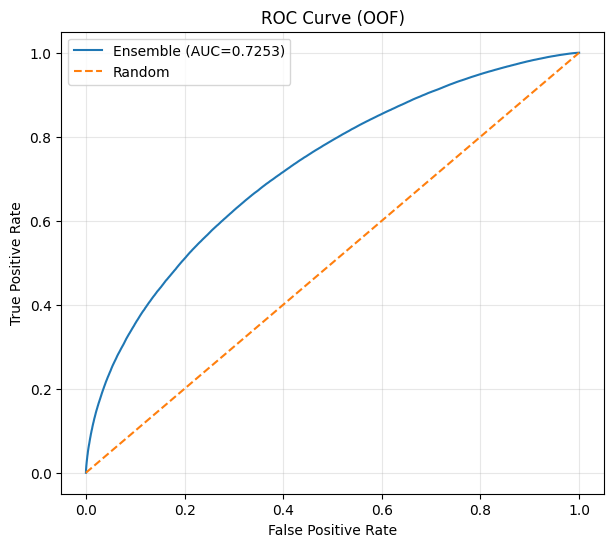

In [18]:
fpr, tpr, _ = roc_curve(y, oof_final)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"Ensemble (AUC={roc_auc:.4f})")
plt.plot([0,1], [0,1], "--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (OOF)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

<h3><b>CREATE SUBMISSION FILE

In [19]:
submission = pd.read_csv("/kaggle/input/playground-series-s5e12/sample_submission.csv")
submission[TARGET] = test_final

In [20]:
submission.to_csv("/kaggle/working/submission_catboost.csv", index=False)
submission.head()

,id,diagnosed_diabetes
0,700000,0.482300
1,700001,0.623678
2,700002,0.730406
3,700003,0.421258
4,700004,0.876052
